## 1. Chargement des données

In [20]:
import pandas as pd
# 1.1 Chargez le CSV
df = pd.read_csv('data.csv', parse_dates=['InvoiceDate'], encoding='ISO-8859-1')
print(f"Données chargées : {df.shape[0]} lignes, {df.shape[1]} colonnes")
# 1.2 Aperçu
df.head()

Données chargées : 541909 lignes, 8 colonnes


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 2. Feature Engineering – RFM

In [21]:
# 2.1 Ne garder que les transactions positives
df_rfm = df[df['Quantity'] > 0].copy()
# 2.2 Création de TotalPrice
df_rfm['TotalPrice'] = df_rfm['Quantity'] * df_rfm['UnitPrice']
# 2.3 Définir la date de référence
import pandas as pd
date_ref = df_rfm['InvoiceDate'].max() + pd.Timedelta(days=1)
# 2.4 Calcul RFM
rfm = df_rfm.groupby('CustomerID').agg(
    Recency = ('InvoiceDate', lambda x: (date_ref - x.max()).days),
    Frequency = ('InvoiceNo','nunique'),
    Monetary = ('TotalPrice','sum')
).reset_index()
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


## 3. Nettoyage & Imputation

In [22]:
from sklearn.impute import SimpleImputer
# 3.1 Imputer les NaN par la médiane
imputer = SimpleImputer(strategy='median')
cols = ['Recency','Frequency','Monetary']
rfm[cols] = imputer.fit_transform(rfm[cols])
rfm.isnull().sum()

CustomerID    0
Recency       0
Frequency     0
Monetary      0
dtype: int64

## 4. Standardisation

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(rfm[cols])
print("Moyennes après standardisation :", X.mean(axis=0))
print("Écarts-types après standardisation :", X.std(axis=0))

Moyennes après standardisation : [ 7.53283380e-17  1.96508708e-17 -4.09393141e-17]
Écarts-types après standardisation : [1. 1. 1.]


## 5. Estimer l'eps (kNN-Distance)

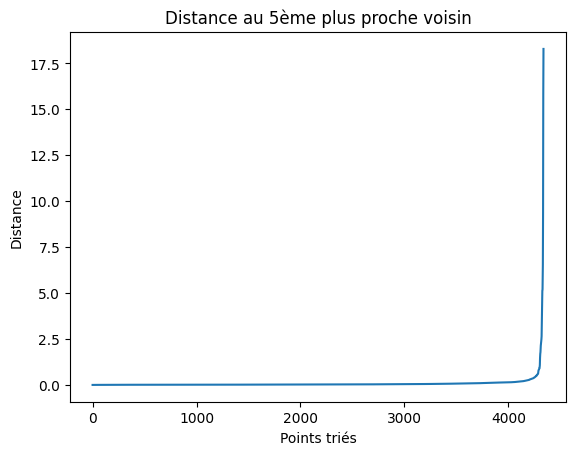

In [27]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
# 5.1 Calculer les distances
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X)
dists,_ = neigh.kneighbors(X)
dist_k = np.sort(dists[:,4])
# 5.2 Tracer
plt.plot(dist_k)
plt.title('Distance au 5ème plus proche voisin')
plt.xlabel('Points triés')
plt.ylabel('Distance')
plt.show()

## 6. Application de DBSCAN

In [28]:
from sklearn.cluster import DBSCAN
# 6.1 Choisissez eps et min_samples
eps=0.8; min_samples=5
# 6.2 Exécuter DBSCAN
db = DBSCAN(eps=eps, min_samples=min_samples)
labels = db.fit_predict(X)
rfm['Cluster'] = labels
# 6.3 Afficher compte par cluster
rfm['Cluster'].value_counts()

Cluster
 0    4298
-1      41
Name: count, dtype: int64

## 7. Évaluation du clustering

Meilleure config : {'min_samples': 5.0, 'eps': 1.7, 'n_clusters': 2.0, 'silhouette': 0.8285571965155689}


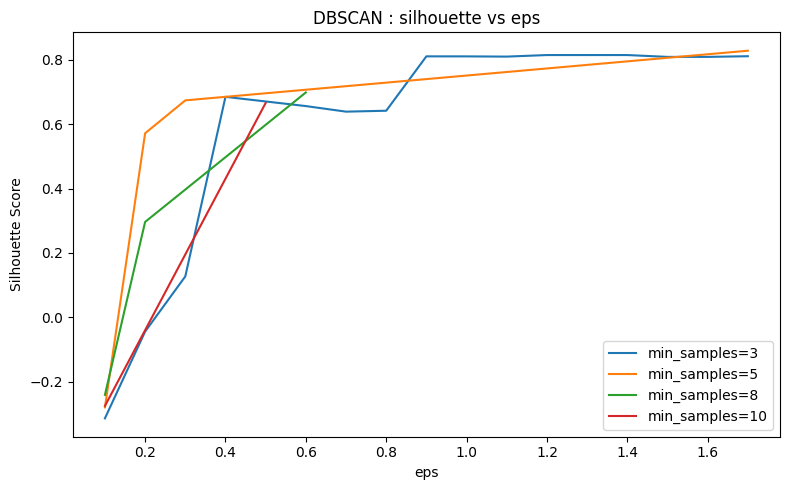

In [31]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Supposons que X soit déjà standardisé (RFM/features)
eps_values = np.linspace(0.1, 3.0, 30)   # à ajuster selon vos distances kNN
min_samples = [3, 5, 8, 10]

results = []
for ms in min_samples:
    for eps in eps_values:
        db = DBSCAN(eps=eps, min_samples=ms).fit(X)
        labels = db.labels_
        # Compter les clusters valides
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters < 2:
            score = np.nan
        else:
            mask = labels != -1
            score = silhouette_score(X[mask], labels[mask])
        results.append((ms, eps, n_clusters, score))

# Mettre en DataFrame pour visualiser
import pandas as pd
df_scores = pd.DataFrame(results, columns=['min_samples','eps','n_clusters','silhouette'])
# Garder seulement où silhouette est définie
df_scores = df_scores.dropna(subset=['silhouette'])

# Trouver la meilleure configuration
best = df_scores.loc[df_scores['silhouette'].idxmax()]
print("Meilleure config :", best.to_dict())

# Visualiser silhouette vs eps pour chaque min_samples
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
for ms in min_samples:
    sub = df_scores[df_scores['min_samples']==ms]
    plt.plot(sub['eps'], sub['silhouette'], label=f'min_samples={ms}')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.title('DBSCAN : silhouette vs eps')
plt.legend()
plt.tight_layout()
plt.show()


## 8. Visualisation des clusters (PCA 2D)

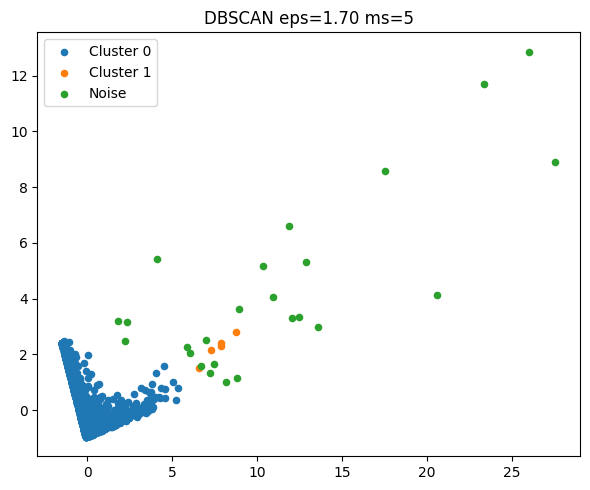

In [35]:
db = DBSCAN(eps=best.eps, min_samples=int(best.min_samples))
labels = db.fit_predict(X)
rfm['Cluster'] = labels

# Refaire la PCA 2D + scatter
from sklearn.decomposition import PCA
coords = PCA(n_components=2, random_state=42).fit_transform(X)
plt.figure(figsize=(6,5))
for lab in set(labels):
    mask = labels == lab
    lbl = 'Noise' if lab == -1 else f'Cluster {lab}'
    plt.scatter(coords[mask,0], coords[mask,1], s=20, label=lbl)
plt.legend()
plt.title(f'DBSCAN eps={best.eps:.2f} ms={int(best.min_samples)}')
plt.tight_layout()
plt.show()

## 9. Analyse finale

In [33]:
# Moyennes RFM par cluster
df_summary = rfm.groupby('Cluster')[cols].mean()
df_summary

,Recency,Frequency,Monetary
Cluster,,,
-1,34.243902,49.073171,66319.180488
0,93.074221,3.844579,1440.744882
